In [1]:
import os 
from pathlib import Path
from dotenv import load_dotenv, find_dotenv

basepath = Path(os.getcwd())
# make sure your working directory is the repository root.
if basepath.name != "idp-radio-1":
    os.chdir(basepath.parent.parent)
    
import os 
import tensorflow as tf
from pathlib import Path

# Specify which GPU(s) to use
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Or 2, 3, etc. other than 0

#config = tf.compat.v1.ConfigProto(device_count={'GPU': 1}, allow_soft_placement=True, log_device_placement=True)
config = tf.compat.v1.ConfigProto(allow_soft_placement=True, log_device_placement=True)
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 1.2
tf.compat.v1.Session(config=config)
tf.__version__

from tensorflow.keras.applications.densenet import DenseNet121

from src.metrics.metrics import F2Score
from src.metrics.losses import WeightedBinaryCrossentropy, compute_class_weight
from src.architectures.simple.simple_base import SimpleBaseArchitecture
from src.utils.save_model import get_experiment, load_model
from src.architectures.benchmarks.benchmark_definitions import benchmark_from_logs, simple_architecture_experiment, CHEXPERT_COLUMNS
from src.utils.crm import CRM, decode_predictions

%load_ext autoreload
%autoreload 2

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

Using TensorFlow backend.


In [2]:
MODEL_ID = '2eb47be0-e88c-11ea-9a58-0242ac110005'
ARCHITECTURE = DenseNet121
NUM_CLASSES = 12

In [3]:
exp_dict = get_experiment(identifier=MODEL_ID)
benchmark = benchmark_from_logs(exp_dict['benchmark'])

Initialzed custom_binary_crossentropy with epsilon 1e-05


In [4]:
def build_model():
    model = SimpleBaseArchitecture(ARCHITECTURE, NUM_CLASSES, train_last_layer_only=False)
    path = str(load_model(identifier=MODEL_ID))
    model.load_weights(path)

    return model

In [5]:
model = build_model()

In [7]:
crm = CRM(model, benchmark.label_columns, dims=(256, 256))

In [14]:
image = 'data/chexpert/full/CheXpert-v1.0-small/valid/patient64582/study1/view1_frontal.jpg'
thresh = 0.3

Pleural Effusion(9) 0.312198
Atelectasis    (7) 0.261084
Consolidation  (5) 0.223503
Edema          (4) 0.193650
Lung Opacity   (2) 0.134016
Pneumonia      (6) 0.074804
Lung Lesion    (3) 0.026138


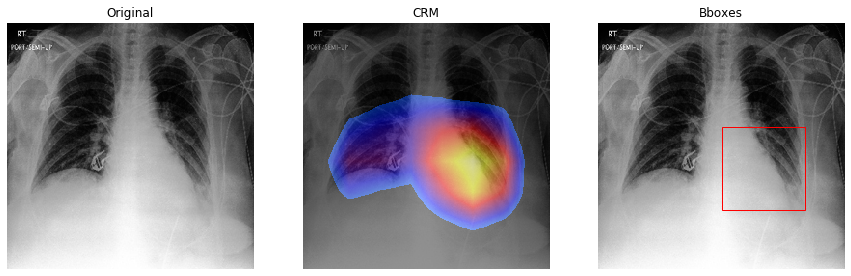

In [19]:
original, resized_crm, img, output = crm.single_image_crm(image, thresh)
top = decode_predictions(crm.classes, output[0], crm.num_classes)[:7]

bbox, plt = crm.plot_crm(original, img, resized_crm, thresh, figsize=(15,10))

for c, i, p in top:
    print('{:15s}({}) {:f}'.format(c, i, p))

plt.show()


Pleural Effusion(9)with probability 0.3121980130672455
Atelectasis    (7)with probability 0.2610839605331421
Consolidation  (5)with probability 0.2235029637813568


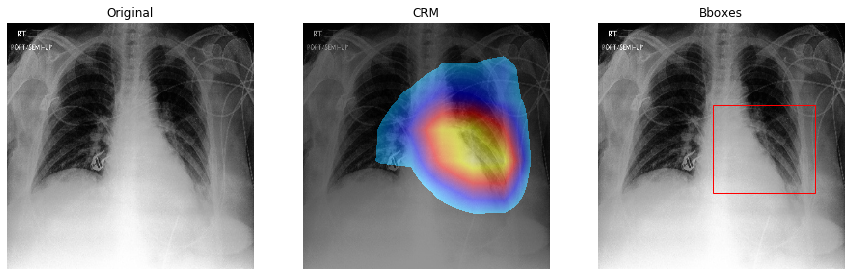

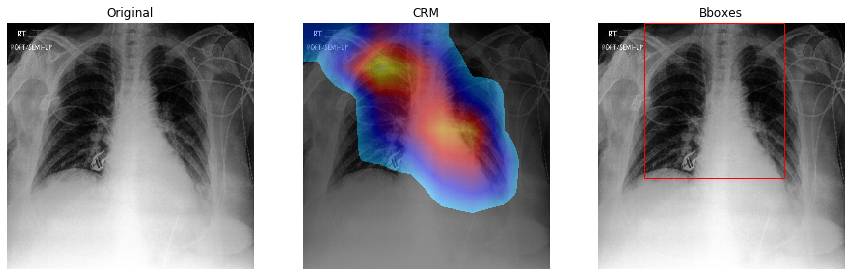

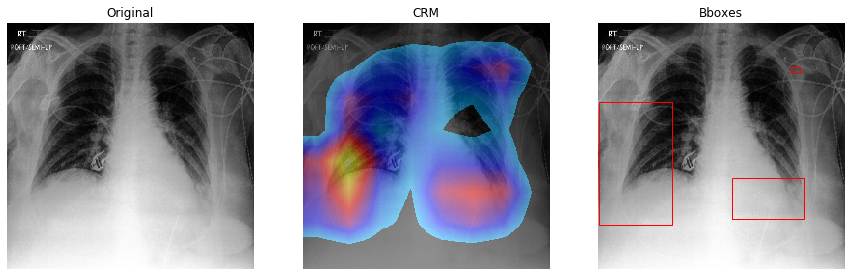

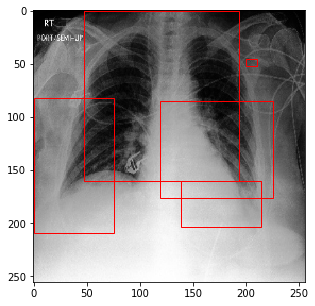

In [20]:
crm.generate_crm_class_plot(image, 0.2, figsize=(15,10))